In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Defining Actions
STILL = 0
FORWARDS = 1
BACKWARDS = -1
motion_list = [STILL, FORWARDS, BACKWARDS]

NOT_TURN = 0
TURN_LEFT = -1
TURN_RIGHT = 1
turn_list = [NOT_TURN, TURN_LEFT, TURN_RIGHT]

GOAL = (5, 6)

# Define grid world
L = 8
W = 8

In [2]:
S = []
for x in range(L):
    for y in range (W):
        for h in range(12):
            S.append((x, y, h))


In [15]:
A = []
for motion in motion_list:
    if motion != STILL:
        for turn in turn_list:
            A.append((motion, turn))
    else:
        A.append((STILL, NOT_TURN))
NA = len(A)

In [8]:
def reward(s):

    # Border states (Red, marked X)
    if s[0] == 0 or s[0] == L - 1 or s[1] == 0 or s[1] == W - 1:
        return -100

    # Lane Markers (Yellow, marked --)
    elif s[0] == 3 and s[1] in [4, 5, 6]:
        return -10

    # Goal state (Green, marked *)
    elif s[0] == GOAL[0] and s[1] == GOAL[1]:
        return 1

    # Every other state has reward 0
    else:
        return 0

In [4]:
def direction(heading):
    dir4 = int((heading + 1) / 3) % 4   # Transform to 4 directions
    x = dir4 % 2 if not dir4 % 2 else 2 - dir4
    y = (dir4 + 1) % 2 if not (dir4 + 1) % 2 else 1 - dir4
    return [x, y]

In [5]:
def err_prob(heading, pe):
    err_headings = []
    for turn in turn_list:
        # The probability of pre-rotating = "pe", and not pre-rotating = "1 - 2 * pe"
        if turn == STILL:
            err_headings.append((heading, 1 - 2 * pe))
        else:
            err_headings.append(((heading + turn) % 12, pe))
    return err_headings

In [6]:
def p_sa(s, a, s_, pe):
    # Pre-rotate probability validity check
    if (pe < 0 or pe > 0.5):
        return ValueError('Invalid error probability pe. pe should be between 0 and 0.5.')

    x, y = s[0], s[1]
    prob = 0
    # Staying still will result in no pre-rotate error. Future state = Current state.
    if a[0] == STILL:
        if s_ == s:
            prob = 1
    # Otherwise, error occurs.
    else:
        for state in err_prob(s[2], pe):
            # Attempting to move off of a grid will result in no linear movement, though rotation portion will still happen.
            x = s[0] + a[0] * direction(state[0])[0]
            if (0 <= x <= L - 1):
                x_p = x
            else:
                x_p = s[0]

            # Consider directions a[0]: FORWARDS (+1) and BACKWARDS (-1)
            y = s[1] + a[0] * direction(state[0])[1]
            if (0 <= y <= W - 1):
                y_p = y
            else:
                y_p = s[1]

            h_p = (state[0] + a[1]) % 12
            s_p = (x_p, y_p, h_p)

            # Check if the "s_" argument is equal to the calculated future states "s_p".
            if s_ == s_p:
                prob = state[1]
                return prob
    return prob

In [7]:
def next_state(s, a, pe):
    p={}
    for state in S:
        if p_sa(s, a, state, pe) > 0:
            p[state] = p_sa(s, a, state, pe)
    return p

In [9]:
def policy_init(S):

    policy = {}

    for s in S:
        # Get the vector from the state to the goal
        dir_vector = [GOAL[0] - s[0], GOAL[1] - s[1]]

        # Already reach goal
        if dir_vector == [0, 0]:
            policy[s] = (STILL, NOT_TURN)
            continue

        # Compute the moving direction
        # Heading +x, which means h in [2, 3, 4]
        if s[2] in [2, 3, 4]:
            # If target is in the right of robot, go forwards, else go backwards
            if dir_vector[0] >= 0:
                motion = FORWARDS
                dir_vector[0] -= 1
            else:
                motion = BACKWARDS
                dir_vector[0] += 1

        # Heading -x, which means h in [8, 9, 10]
        if s[2] in [8, 9, 10]:
            # If target is in the left of robot, go forwards, else go backwards
            if dir_vector[0] <= 0:
                motion = FORWARDS
                dir_vector[0] += 1
            else:
                motion = BACKWARDS
                dir_vector[0] -= 1

        # Heading +y,which means h in [11, 0, 1]
        if s[2] in [11, 0, 1]:
            # If target is in front of robot, go forwards, else go backwards
            if dir_vector[1] >= 0:
                motion = FORWARDS
                dir_vector[1] -= 1
            else:
                motion = BACKWARDS
                dir_vector[1] += 1

        # Heading -y, which means h in [5,6,7]
        if s[2] in [5, 6, 7]:
            # If target is in front of robot, go backwards, else go forwards
            if dir_vector[1] <= 0:
                motion = FORWARDS
                dir_vector[1] += 1
            else:
                motion = BACKWARDS
                dir_vector[1] -= 1

        # Compute the turn direction
        # Get the vector angle theta
        theta = np.arctan2(dir_vector[1], dir_vector[0]) * 180 / np.pi
        angle_diff = s[2] * 30 - (90 - theta)
        angle_diff = angle_diff % 180
        threshold = 0

        # if target is in the left front of robot or right back, turn left
        # if they are in one line, not turn
        # else turn right 
        if (angle_diff > threshold) and (angle_diff < 90):
            turn = TURN_LEFT
        elif angle_diff <= threshold or angle_diff == 90:
            turn = NOT_TURN
        else:
            turn = TURN_RIGHT

        policy[s] = (motion, turn)

    return policy

In [10]:
def generate_trajectory(policy, s0, pe = 0, show = True):
    # policy: a directory of all policy
    # s0 = (x, y, h) : initial state
    # pe: the error probability pe to pre-rotate when choosing to move.
    # Return: Trajectory including passing states and actions on each state

    # Confirm the feasibility of pe
    if (pe < 0 or pe > 0.5):
        return ValueError('Invalid error probability pe. pe should be between 0 and 0.5.')

    # Generate the trajectory
    trajectory = []
    s_now = s0

    trajectory.append([s_now, policy[s_now]])

    # The robot keeps moving until it reaches target
    while (s_now[0] != GOAL[0] or s_now[1] != GOAL[1]):

        # Get probability of all possible next states
        P_states = next_state(s_now, policy[s_now], pe)
        
        states = list(P_states.keys())
        probs = list(P_states.values())
        # Choose next states according to probs
        if len(probs) == 1:    
            s_next = states[0]
            s_now = s_next
        else:
            # Generate a random float between (0,1)
            x = random.random()
            if x <= probs[0]:
                s_next = states[0]
                s_now = s_next
            elif probs[0] < x <= (probs[0] + probs[1]):
                s_next = states[1]
                s_now = s_next
            else:
                s_next = states[2]
                s_now = s_next
        # Add state and action now in to trajectory
        trajectory.append([s_now, policy[s_now]])

    # Grid world initialization
    fig = plt.figure(figsize = (L - 2, W - 2))
    map = fig.add_subplot(1,1,1)
    plt.xlim((0, L))
    plt.ylim((0, W))
    x_locator = plt.MultipleLocator(1)
    y_locator = plt.MultipleLocator(1)
    map.xaxis.set_minor_locator(x_locator)
    map.yaxis.set_minor_locator(y_locator)
    plt.grid(color = 'k', which = 'minor')
    plt.tick_params(width = 0)
    plt.tick_params(which = 'minor', width = 0)
    x_labels = np.arange(0, L, 1)
    y_labels = np.arange(0, W, 1)
    plt.xticks(x_labels + 0.5, x_labels)
    plt.yticks(y_labels + 0.5, y_labels)

    # Place red markers
    edge1 = plt.Rectangle((0,0), 1, L, color = 'r')
    edge2 = plt.Rectangle((0,0), W, 1, color = 'r')
    edge3 = plt.Rectangle((L - 1,0), 1, L, color = 'r')
    edge4 = plt.Rectangle((0,W - 1), W, 1, color = 'r')
    map.add_patch(edge1)
    map.add_patch(edge2)
    map.add_patch(edge3)
    map.add_patch(edge4)

    # Place yellow markers
    yellow = plt.Rectangle((3, 4), 1, 3, color = 'yellow', alpha = 1)
    map.add_patch(yellow)

    # Place green goal
    goal = plt.Rectangle((5, 6), 1, 1, color = 'greenyellow', alpha = 1)
    map.add_patch(goal)

    # Plot the start state
    plt.plot(s0[0] + 0.5, s0[1] + 0.5, 'o', markersize = '10',color = 'b')
    map.arrow(s0[0] + 0.5, s0[1] + 0.5, 0.4 * np.sin(30 * s0[2] * np.pi/180),0.4 * np.cos(30 * s0[2] * np.pi/180), head_width = 0.1, head_length = 0.2, fc = 'k', ec = 'k')

    # Plot all passing states
    for i in range(0, len(trajectory) - 1):
        x1 = trajectory[i][0][0]
        y1 = trajectory[i][0][1]
        x2 = trajectory[i + 1][0][0]
        y2 = trajectory[i + 1][0][1]
        h = trajectory[i + 1][0][2]
        plt.plot([x1 + 0.5, x2 + 0.5], [y1 + 0.5, y2 + 0.5], 'k--')
        plt.plot(x2 + 0.5, y2 + 0.5, 'o', markersize = '10',color = 'b')
        map.arrow(x2 + 0.5, y2 + 0.5, 0.4*np.sin(30 * h * np.pi/180), 0.4 * np.cos(30 * h * np.pi/180),
                 head_width = 0.1, head_length = 0.2, fc = 'k', ec = 'k')

    # Plot the grid world
    if show:
        plt.show()

    return trajectory

In [11]:
def policy_eval(S, V , policy, reward, pe = 0, discount_factor = 1, threshold = 0.001):

    if len(V)==0:
        for s in S:
            V[s] = 0.0

    while True:
        diff = 0
        # For each state, perform the evaluation
        for s in S:
            v = 0
            # Look at the possible next states:
            P_states = next_state(s, policy[s], pe)
            states = list(P_states.keys())
            probs = list(P_states.values())
            # Calculate the value:
            for i in range(len(states)):
            # Calculate the expected value
                s_next = states[i]
                v = v + probs[i] * (reward(s_next) + discount_factor * V[s_next])
            # Calculate how much the value function changed:
            diff = max(diff, np.abs(v - V[s]))
            # Update the value function
            V[s] = v
        # Stop evaluating once the value function change is below a threshold
        if diff < threshold:
            break
    return V

V = policy_eval(S, {}, policy_init(S), reward, 0, 0.9, 0.01)
s0 = (1, 6, 6)
print("The value V(s0) is:", V[s0])

The value V(s0) is: -1.4636516721127877


In [12]:
def policy_one_step_lookahead(S, V, reward, pe = 0, discount_factor = 1):
    
    policy = {}
    
    for s in S: 
        # Initialize all action value as 0.
        action = np.zeros(NA)
        for i in range(NA):
            # Check the possible next state for each action.
            P_states = next_state(s, A[i], pe)
            states=list(P_states.keys())
            probs=list(P_states.values()) 
            # Calculate value of each action.
            for j in range(len(states)):
                action[i] += probs[j] * (reward(states[j]) + discount_factor * V[states[j]])

       # Get the best action 
        best_action_index = np.argmax(action)
        policy[s] = A[best_action_index]

    return policy

In [13]:
def policy_iteration(S, V, policy, reward, pe = 0, discount_factor = 1.0):
    while True:
        # Calculate value of each state
        V = policy_eval(S, V, policy, reward, pe, discount_factor, 0.01)
        # Update policy by one step lookahead
        policy_new = policy_one_step_lookahead(S, V, reward, pe, discount_factor)
        # If policy doesn't change, the iteration is done
        if policy_new == policy:
            return policy, V
        else:
            policy = policy_new

3.8737050904194734


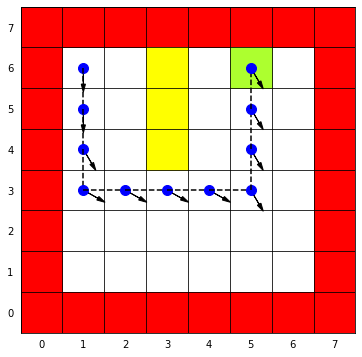

In [16]:
optimal_policy, optimal_V = policy_iteration(S, {}, policy_init(S), reward, 0, 0.9)
print(optimal_V[(1, 6, 6)])
trajectory = generate_trajectory(optimal_policy, s0 = (1, 6, 6), pe = 0, show = True)

In [ ]:
def value_iteration(S, reward, pe = 0, discount_factor = 0.9, threshold = 1):
    V = {}
    for s in S:
        V[s] = 0

    while True:
        diff = 0
        for s in S: 
        # Initialize all action value as 0.
            action = np.zeros(NA)
            for i in range(NA):
            # Check the possible next state for each action.
                P_states = next_state(s, A[i], pe)
                states=list(P_states.keys())
                probs=list(P_states.values()) 
            # Calculate value of each action.
                for j in range(len(states)):
                    action[i] += probs[j] * (reward(states[j]) + discount_factor * V[states[j]])
            
            # Get the value of the best action
            value_best_action = np.max(action)
            
            # V(H+1) is the best_action value
            diff = max(diff, np.abs(value_best_action - V[s]))
            
            # Update value function
            V[s] = value_best_action
        if diff < threshold:
            break
    return V 